In [1]:
import warnings
warnings.filterwarnings('ignore')

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras import utils
from keras.layers import BatchNormalization
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Load Data

In [3]:
# path to image files
infected_path = r'C:\Users\MQ0\Downloads\cell_images\Parasitized'
uninfected_path = r'C:\Users\MQ0\Downloads\cell_images\Uninfected'

# variables to store data
data = []
labels = []

# read in every image as numpy array
label = 0
for x in [uninfected_path,infected_path]:  
    for im in os.listdir(x):
        if 'Thumbs.db' not in im:
            image = Image.open(x + '\\' + im).resize((50,50))
            data.append(np.asarray(image))
            labels.append(label)
    label += 1

In [4]:
# convert data to numpy array
data = np.array(data)
labels = np.array(labels)

# split train test
X_train, X_test, y_train, y_test = train_test_split(data, labels, shuffle = True)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

## Train Model
First we train a Convolutional Model without Residual Connections, we will start with a simple model, and keep adding layers until there are no more improvements.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Best Validation Accuracy is 0.9578091502189636
Best parameters: [(3, 7), 64, (32, 32)]


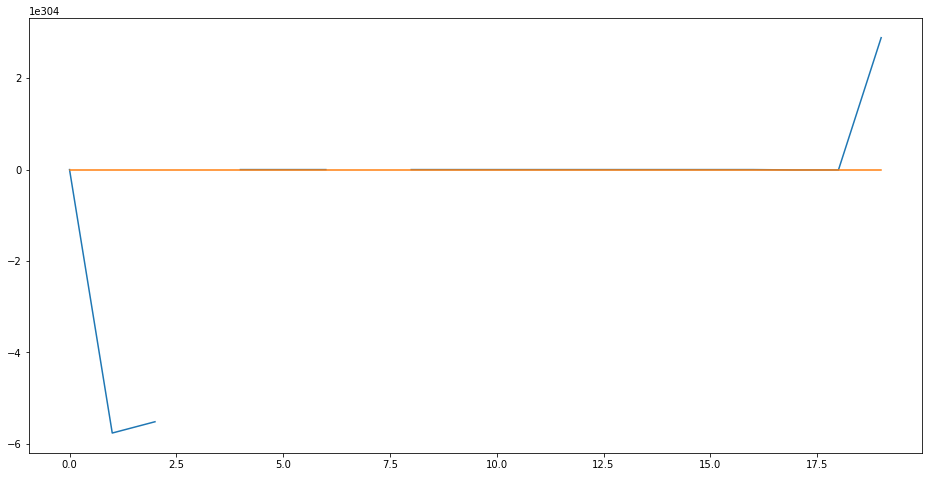

In [5]:
# function to create a simple model
def make_model(kernel_sizes = (3,3), dense = 64, filters = (32,32)):
    cnn = Sequential()
    cnn.add(Conv2D(filters[0], kernel_size=kernel_sizes[0],activation='relu',input_shape=(50,50,3)))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Conv2D(filters[1], kernel_size=kernel_sizes[1], activation='relu'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Flatten())
    cnn.add(Dense(dense, activation='relu'))
    cnn.add(Dense(1, activation='sigmoid'))
    cnn.compile(optimizer='adam',loss="binary_crossentropy",metrics=['accuracy'])
    return cnn



# parameters to tune
filters = [(16,16),(32,32),(32,64)]
kernel_sizes = [(3,3),(5,5),(7,7),(5,7),(3,5),(3,7)]
dense = [512,256,128,64]
config_list = []
for x in kernel_sizes:
    for y in dense:
        for z in filters:
            config_list += [[x,y,z]]

# variables to store training results    
validation_history = []        
average_validation = np.empty((len(config_list), 20))
average_training = np.empty((len(config_list), 20))
average_loss = np.empty((len(config_list), 20))
average_val_loss = np.empty((len(config_list), 20))
i=0

    
# for each set of parameters
for config in config_list:
    
    # create and fit model
    model = make_model(config[0],config[1],config[2])
    history = model.fit(X_train, y_train, validation_split = 0.25, epochs = 20, verbose = 0)
    

    # store training history 
    validation_history += [np.max(history.history['val_accuracy'])]
    average_validation[i] = history.history['val_accuracy']
    average_training[i] = history.history['accuracy']
    average_loss[i] = history.history['loss']
    average_val_loss[i] = history.history['val_loss']

print('Best Validation Accuracy is ' + str(np.max(validation_history)))
print('Best parameters: ' + str(config_list[np.argmax(validation_history)]))

plt.figure(figsize=(16,8))
plt.plot(np.mean(average_validation, axis = 0), label = 'average validation score')
plt.plot(np.mean(average_training, axis = 0), label = 'average training score')

Next we try a model with 3 con2d layers and 3 dense layers. 

Best Validation Accuracy is 0.9618734121322632
Best parameters: [(3, 3, 3), (64, 32), (16, 16, 32)]


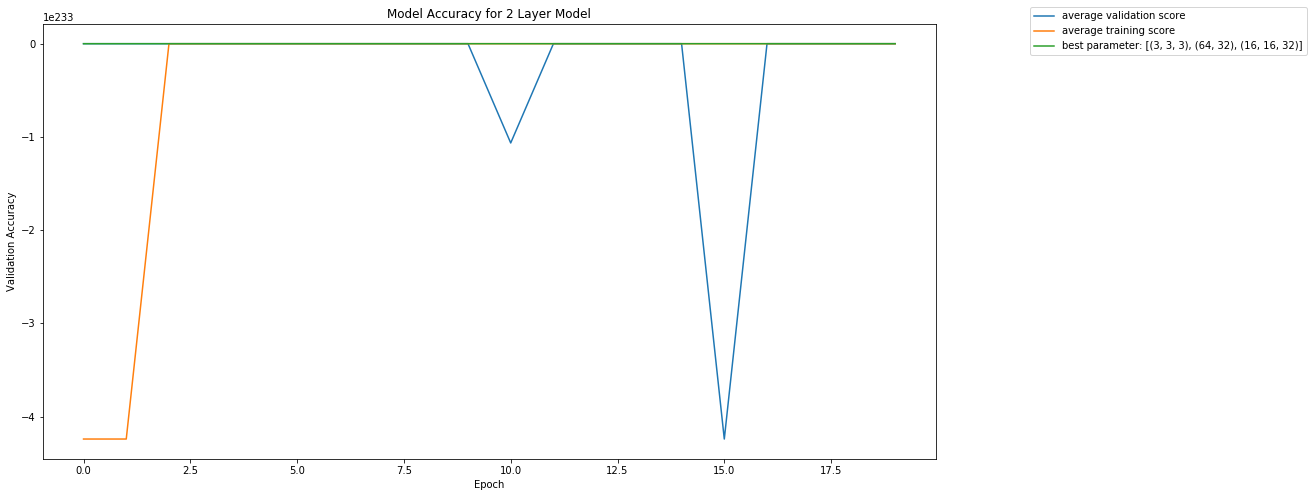

In [6]:
# function to create a simple model
def make_model1(kernel_sizes = (3,3,3), dense = (64,32), filters = (32,32,32)):
    cnn = Sequential()
    cnn.add(Conv2D(filters[0], kernel_size=kernel_sizes[0],activation='relu',input_shape=(50,50,3)))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Conv2D(filters[1], kernel_size=kernel_sizes[1], activation='relu'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Conv2D(filters[2], kernel_size=kernel_sizes[2], activation='relu'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Flatten())
    cnn.add(Dense(dense[0], activation='relu'))
    cnn.add(Dense(dense[1], activation='relu'))
    cnn.add(Dense(1, activation='sigmoid'))
    cnn.compile(optimizer='adam',loss="binary_crossentropy",metrics=['accuracy'])
    return cnn



# parameters to tune
filters = [(16,16,32),(16,32,64),(32,32,32)]
kernel_sizes = [(3,3,3),(5,5,5),(7,7,7),(3,5,7),(2,2,2)]
dense = [(512,256),(128,64),(64,32)]
config_list = []
for x in kernel_sizes:
    for y in dense:
        for z in filters:
            config_list += [[x,y,z]]

# variables to store training results    
validation_history = []        
average_validation = np.empty((len(config_list), 20))
average_training = np.empty((len(config_list), 20))
i=0

    
# for each set of parameters
for config in config_list:
    
    # create and fit model
    model = make_model1(config[0],config[1],config[2])
    history = model.fit(X_train, y_train, validation_split = 0.25, epochs = 20, verbose = 0)
    
    # store training history 
    validation_history += [np.max(history.history['val_accuracy'])]
    average_validation[i] = history.history['val_accuracy']
    average_training[i] = history.history['accuracy']

print('Best Validation Accuracy is ' + str(np.max(validation_history)))
print('Best parameters: ' + str(config_list[np.argmax(validation_history)]))

plt.figure(figsize=(16,8))
plt.plot(np.mean(average_validation, axis = 0), label = 'average validation score')
plt.plot(np.mean(average_training, axis = 0), label = 'average training score')
plt.plot(average_validation[np.argmax(validation_history)],
         label = 'best parameter: ' + str(config_list[np.argmax(validation_history)]))
plt.title('Model Accuracy for 2 Layer Model')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.1, 1.05))

Since the improvement is so little (<0.01) in accuracy, we will stop at 3 layers. 

## Data Augmentation

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# create generator instance
datagen = ImageDataGenerator(horizontal_flip = True,
                             vertical_flip = True,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             zoom_range = 0.2,
                             rotation_range = 90)

# augment data
it = datagen.flow(X_train, y_train)


config = config_list[np.argmax(validation_history)]

model_aug = make_model1(config[0],config[1],config[2])
aug_history = model_aug.fit_generator(it, epochs = 20, verbose = 0, steps_per_epoch=646)

NameError: name 'config_list' is not defined

In [8]:
model_aug.evaluate(X_test, y_test)

6890/6890 [==============================] - 5s 793us/step


[0.13021484233211883, 0.9563134908676147]

It seems that data augmentation had little improvement on our model performance.

## Resnet
We first build a 50 layer residual network.

In [5]:
from keras.models import Model



def identity_block(X, kernel_sizes, filters, skip = True):

    # Save the input value
    X_shortcut = X
    
    # 1st layer of block
    X = Conv2D(filters = filters[0], kernel_size = (1, 1), strides = (1,1), padding='valid')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # 2nd layer of block
    X = Conv2D(filters = filters[1], kernel_size = kernel_sizes, strides = (1, 1), padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = filters[2], kernel_size = (1, 1), strides = (1, 1), padding='valid')(X)
    X = BatchNormalization()(X)

    # if we are building a resnet
    if skip:
        X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [6]:
def convolutional_block(X, kernel_sizes, filters, s=2, skip = True):

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=filters[0], kernel_size=(1, 1), strides=(s, s), padding='valid')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=filters[1], kernel_size=kernel_sizes, strides=(1, 1), padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=filters[2], kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization()(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters=filters[2], kernel_size=(1, 1), strides=(s, s), padding='valid')(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)

    # if we are building a resnet
    if skip:
        X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [7]:
def res_model(skip = True):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input((50,50,3))
    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # Stage 2
    X = convolutional_block(X, 3, [32, 32, 32],s = 1, skip = skip)
    X = identity_block(X, 3, [32, 32, 32], skip = skip)
    X = identity_block(X, 3, [32, 32, 32], skip = skip)

    # Stage 3
    X = convolutional_block(X, 3, [32, 32, 32], s=2, skip = skip)
    X = identity_block(X, 3, [32, 32, 32], skip = skip)
    X = identity_block(X, 3, [32, 32, 32], skip = skip)
    X = identity_block(X, 3, [32, 32, 32], skip = skip)
    
    # Stage 4
    X = convolutional_block(X, 3, [32, 32, 32],  s=2, skip = skip)
    X = identity_block(X, 3, [32, 32, 32], skip = skip)
    X = identity_block(X, 3, [32, 32, 32], skip = skip)
    X = identity_block(X, 3, [32, 32, 32], skip = skip)
    X = identity_block(X, 3, [32, 32, 32], skip = skip)
    
    # Stage 5
    X = convolutional_block(X, 3, [32, 32, 32], s=2, skip = skip)
    X = identity_block(X, 3, [32, 32, 32], skip = skip)
    X = identity_block(X, 3, [32, 32, 32], skip = skip)
    
    X = AveragePooling2D(pool_size=(2,2), padding='same')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X)
    
    return model

We then fit the model with residual connections. 

In [13]:
model = res_model()
model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
model.fit(X_train, y_train, epochs = 20,verbose = 0)
model.evaluate(X_test,y_test)

6890/6890 [==============================] - 8s 1ms/step


[0.13242269822346325, 0.9541364312171936]

Now compare to the model with no residual connections.

In [ ]:
model = res_model(False)
model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
model.fit(X_train, y_train, epochs = 20, verbose = 0)
model.evaluate(X_test,y_test)

We can see that with residual connections we get better results.